In [4]:
# *****************************************************************************
#
#
# Purpose: Calibration of the Sick-Sicker 4-state Markov Model using
#          Random Search via Latin-Hypercube Sampling (LHS)
#
# Authors:
# This work is developed by the Decision Analysis in R for Technologies in Health
# (DARTH) workgroup:
#
# - Fernando Alarid-Escudero, PhD
# - Eva A. Enns, MS, PhD
# - M.G. Myriam Hunink, MD, PhD
# - Hawre J. Jalal, MD, PhD
# - Eline Krijkamp, PhD
# - Petros Pechlivanoglou, PhD
# - Alan Yang, MSc
#
# *****************************************************************************
#
# Notes:
#
# Please acknowledge our work. See details to cite below:
#
# - Alarid-Escudero F, MacLehose RF, Peralta Y, Kuntz KM, Enns EA.
#   Non-identifiability in model calibration and implications for
#   medical decision making. Med Decis Making. 2018; 38(7):810-821.
#
# - Jalal H, Pechlivanoglou P, Krijkamp E, Alarid-Escudero F, Enns E,
#   Hunink MG. An Overview of R in Health Decision Sciences.
#   Med Decis Making. 2017; 37(3): 735-746.
#
# *****************************************************************************

# ******************************************************************************
# 01 Calibration Overview ------------------------------------------------------
# ******************************************************************************

### 01.01 Model description  ---------------------------------------------------
# Model: Sick-Sicker 4-state Markov Model
# Inputs to be calibrated: p_S1S2, hr_S1, hr_S2
# Targets: Surv, Prev, PropSick

### 01.02 Calibration method  --------------------------------------------------
# Search method: Random search using Latin-Hypercube Sampling
# Goodness-of-fit measure: Sum of Log-Likelihood

# ******************************************************************************
# 02 Setup ---------------------------------------------------------------------
# ******************************************************************************

In [1]:
### 02.01 Clear environment  ---------------------------------------------------
rm(list = ls())

In [2]:
### 02.02 Load packages  -------------------------------------------------------
# Install pacman if not present
# if (!requireNamespace("pacman", quietly = TRUE)) install.packages("pacman")
# Load pacman
library(pacman)
# Load (install if needed) CRAN packages
p_load(
   lhs,         # Latin Hypercube Sampling
   plotrix,     # Plotting with confidence intervals
   psych,       # Pairs panels
   scatterplot3d# 3D scatter plots
)

# calibration functionality
library(lhs)

# visualization
library(plotrix)
library(psych)
library(scatterplot3d) # now that we have three inputs to estimate, we'll need higher dimension visualization


Installing package into ‘/home/giparra/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)


scatterplot3d installed



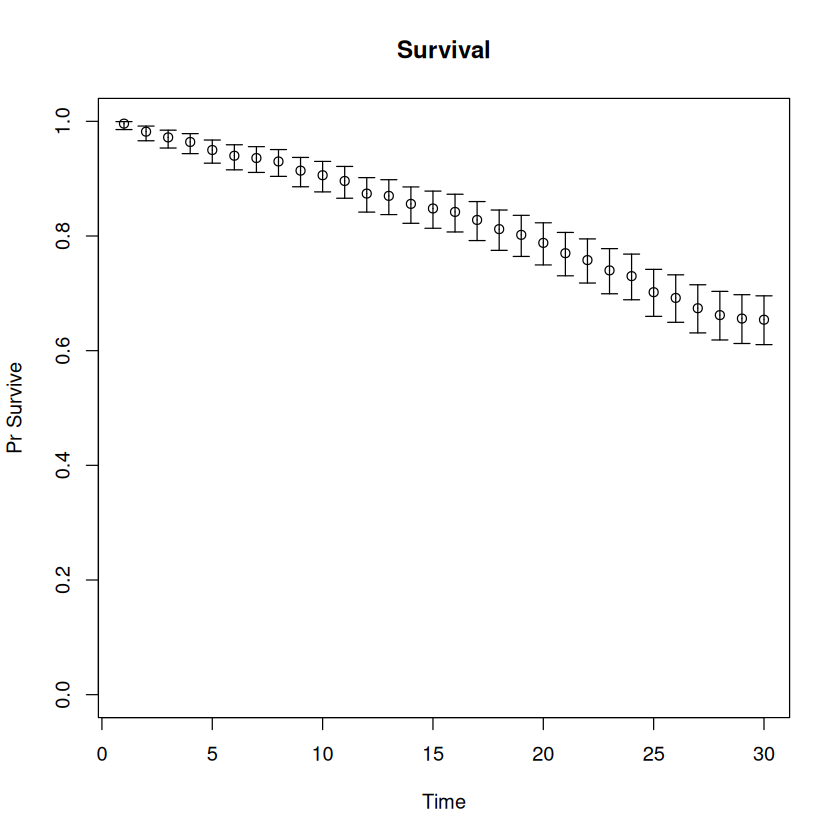

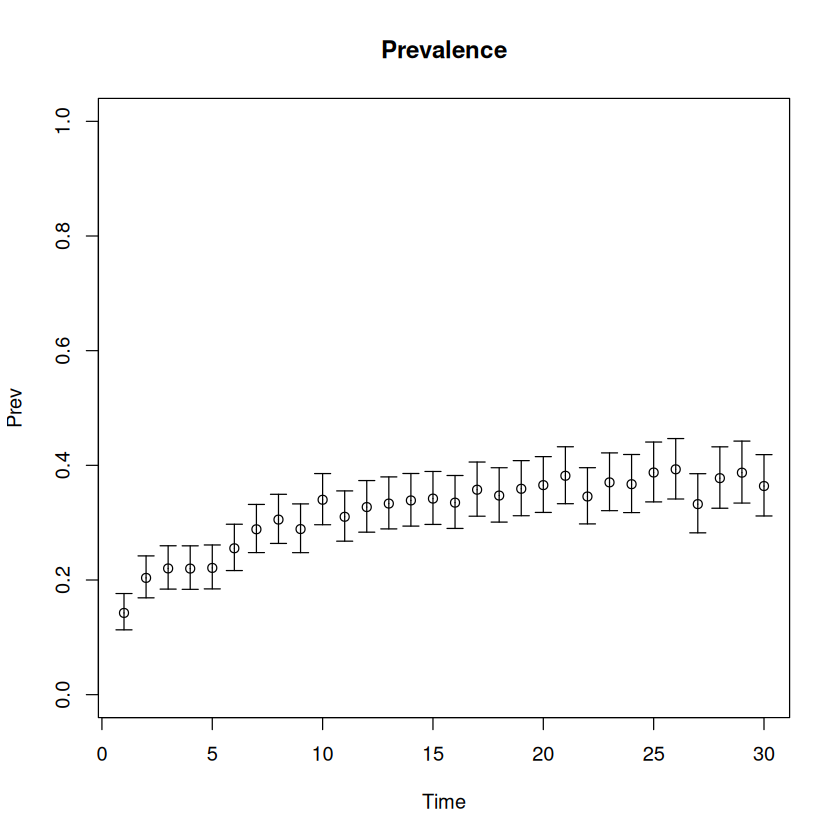

$Surv
        1         2         3         4         5         6         7         8 
0.9950000 0.9885362 0.9810784 0.9728008 0.9637994 0.9541472 0.9439082 0.9331413 
        9        10        11        12        13        14        15        16 
0.9219015 0.9102402 0.8982055 0.8858421 0.8731922 0.8602948 0.8471865 0.8339014 
       17        18        19        20        21        22        23        24 
0.8204713 0.8069256 0.7932918 0.7795955 0.7658602 0.7521079 0.7383588 0.7246318 
       25        26        27        28        29        30 
0.7109441 0.6973115 0.6837488 0.6702694 0.6568856 0.6436086 

$Prev
        1         2         3         4         5         6         7         8 
0.1507538 0.2018249 0.2267624 0.2443252 0.2593508 0.2731265 0.2860289 0.2981972 
        9        10        11        12        13        14        15        16 
0.3097057 0.3206084 0.3309506 0.3407725 0.3501104 0.3589973 0.3674630 0.3755352 
       17        18        19        20        21        22        23        24 
0.3832387 0.3905968 0.3976304 0.4043591 0.4108009 0.4169723 0.4228887 0.4285642 
       25        26        27        28        29        30 
0.4340120 0.4392445 0.4442729 0.4491079 0.4537594 0.4582367 

$PropSick
       10        20        30 
0.5372139 0.3734392 0.2997246

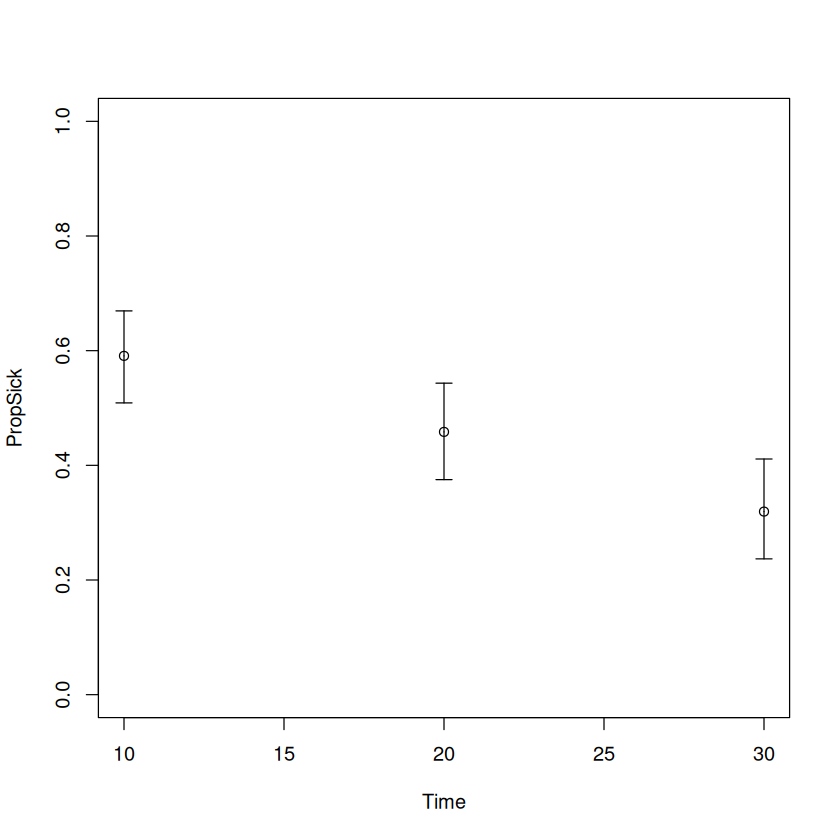

In [5]:
# ******************************************************************************
# 03 Load calibration targets --------------------------------------------------
# ******************************************************************************

### 03.01 Load target data  ----------------------------------------------------
load("../../data/SickSicker_CalibTargets.RData")
lst_targets <- SickSicker_targets

### 03.02 Visualize calibration targets  ---------------------------------------
# TARGET 1: Survival ("Surv")
plotrix::plotCI(x = lst_targets$Surv$time, y = lst_targets$Surv$value,
                ui = lst_targets$Surv$ub,
                li = lst_targets$Surv$lb,
                ylim = c(0, 1),
                xlab = "Time", ylab = "Pr Survive", main = "Survival")

# TARGET 2: Prevalence ("Prev")
plotrix::plotCI(x = lst_targets$Prev$time, y = lst_targets$Prev$value,
                ui = lst_targets$Prev$ub,
                li = lst_targets$Prev$lb,
                ylim = c(0, 1),
                xlab = "Time", ylab = "Prev", main = "Prevalence")

# TARGET 3: Proportion who are Sick ("PropSick"), among all those afflicted (Sick+Sicker)
plotrix::plotCI(x = lst_targets$PropSick$time, y = lst_targets$PropSick$value,
                ui = lst_targets$PropSick$ub,
                li = lst_targets$PropSick$lb,
                ylim = c(0, 1),
                xlab = "Time", ylab = "PropSick")


# ******************************************************************************
# 04 Load model as a function --------------------------------------------------
# ******************************************************************************

### 04.01 Source model function  -----------------------------------------------
# Function inputs: parameters to be estimated through calibration
# Function outputs: model predictions corresponding to target data
source("../../code/Functions/SickSicker_MarkovModel_Function.R") # creates the function run_sick_sicker_markov()

### 04.02 Test model function  -------------------------------------------------
v_params_test <- c(p_S1S2 = 0.105, hr_S1 = 3, hr_S2 = 10)
run_sick_sicker_markov(v_params_test) # Test: function works correctly


In [6]:
# ******************************************************************************
# 05 Calibration specifications ------------------------------------------------
# ******************************************************************************

### 05.01 Set random seed  -----------------------------------------------------
set.seed(072218) # For reproducible sequence of random numbers

### 05.02 Define calibration parameters  ---------------------------------------
# number of random samples
n_samp <- 1000

# names and number of input parameters to be calibrated
v_param_names <- c("p_S1S2","hr_S1","hr_S2")
n_param <- length(v_param_names)

# Search space bounds
lb <- c(p_S1S2 = 0.01, hr_S1 = 1.0, hr_S2 = 5) # lower bound
ub <- c(p_S1S2 = 0.50, hr_S1 = 4.5, hr_S2 = 15) # upper bound

### 05.03 Define calibration targets  ------------------------------------------
v_target_names <- c("Surv", "Prev", "PropSick")
n_target <- length(v_target_names)

In [16]:
# ******************************************************************************
# 06 Run calibration using Random Search (LHS) ---------------------------------
# ******************************************************************************

### 06.01 Record start time  ---------------------------------------------------
t_init <- Sys.time()

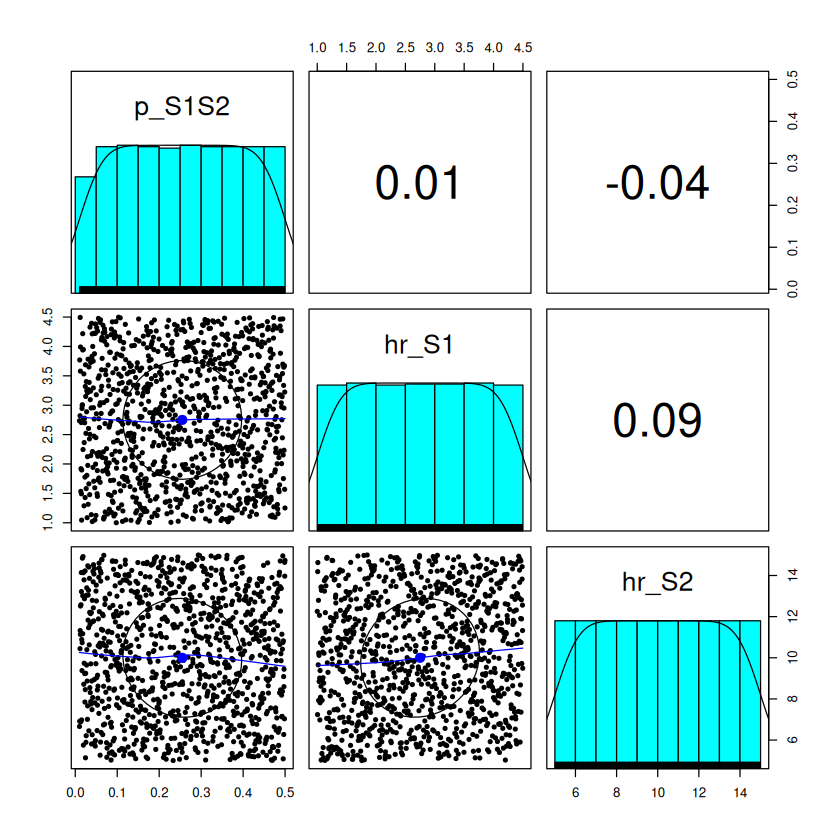

In [7]:
### 06.02 Sample input values using Latin Hypercube Sampling  ------------------

# Sample unit Latin Hypercube
m_lhs_unit <- randomLHS(n_samp, n_param)

# Rescale to min/max of each parameter
m_param_samp <- matrix(nrow = n_samp, ncol = n_param)
for (i in 1:n_param) {
  m_param_samp[, i] <- qunif(m_lhs_unit[, i],
                             min = lb[i],
                             max = ub[i])
}
colnames(m_param_samp) <- v_param_names

### 06.03 Visualize parameter samples  -----------------------------------------
pairs.panels(m_param_samp)

In [18]:
### 06.04 Run the model and calculate goodness-of-fit for each sample  ---------

# initialize goodness-of-fit matrix
m_GOF <- matrix(nrow = n_samp, ncol = n_target)
colnames(m_GOF) <- paste0(v_target_names, "_fit")

In [19]:
for (j in 1:n_samp) {
  model_res <- run_sick_sicker_markov(v_params = m_param_samp[j, ])
  
  m_GOF[j, 1] <- sum(dnorm(x = lst_targets$Surv$value,
                           mean = model_res$Surv,
                           sd = lst_targets$Surv$se,
                           log = T))
  
  m_GOF[j, 2] <- sum(dnorm(x = lst_targets$Prev$value,
                           mean = model_res$Prev,
                           sd = lst_targets$Prev$se,
                           log = T))
  
  m_GOF[j, 3] <- sum(dnorm(x = lst_targets$PropSick$value,
                           mean = model_res$PropSick,
                           sd = lst_targets$PropSick$se,
                           log = T))
}

In [20]:
### 06.05 Calculate overall GOF  -----------------------------------------------
# can give different targets different weights
v_weights <- matrix(1, nrow = n_target, ncol = 1)
# matrix multiplication to calculate weight sum of each GOF matrix row
v_GOF_overall <- c(m_GOF %*% v_weights)
# Store in GOF matrix with column name "Overall"
m_GOF <- cbind(m_GOF, Overall_fit = v_GOF_overall)

### 06.06 Calculate computation time  ------------------------------------------
comp_time <- Sys.time() - t_init
comp_time

Time difference of 9.696273 secs

In [21]:
# ******************************************************************************
# 07 Explore calibration results -----------------------------------------------
# ******************************************************************************

### 07.01 Identify best-fitting parameter sets  --------------------------------
# Arrange parameter sets in order of fit
m_calib_res <- cbind(m_param_samp, m_GOF)
m_calib_res <- m_calib_res[order(-m_calib_res[, "Overall_fit"]), ]

In [22]:
# Examine the top 10 best-fitting sets
m_calib_res[1:10, ]

p_S1S2,hr_S1,hr_S2,Surv_fit,Prev_fit,PropSick_fit,Overall_fit
0.08197110,2.660610,13.107982,93.64201,76.95138,4.2061088,174.7995
0.08219101,3.901892,12.433768,92.49045,76.62123,4.9654853,174.0772
0.07922117,3.426064,10.779210,93.15542,75.40678,5.3731621,173.9354
0.09135567,1.723981,14.303741,91.24810,77.01577,5.1014789,173.3653
0.08725553,2.896138,11.226633,93.20751,72.45478,6.0551740,171.7175
0.09118731,2.373684,12.095516,92.60154,72.38638,5.9895174,170.9774
0.08965952,3.552226,12.547011,90.18529,74.80504,5.8594162,170.8498
0.07509107,4.027888,9.278804,90.86523,74.05501,5.5402634,170.4605
0.08609420,4.295030,9.620468,96.17461,67.01387,6.2530247,169.4415
0.07185352,3.597443,12.838909,95.41440,72.60259,0.9067274,168.9237


In [23]:
m_calib_res[1000, ]

p_S1S2         hr_S1         hr_S2      Surv_fit      Prev_fit 
    0.4945418     3.6986110    14.9549132 -1458.6548998 -1420.9558105 
 PropSick_fit   Overall_fit 
 -108.6021258 -2988.2128360

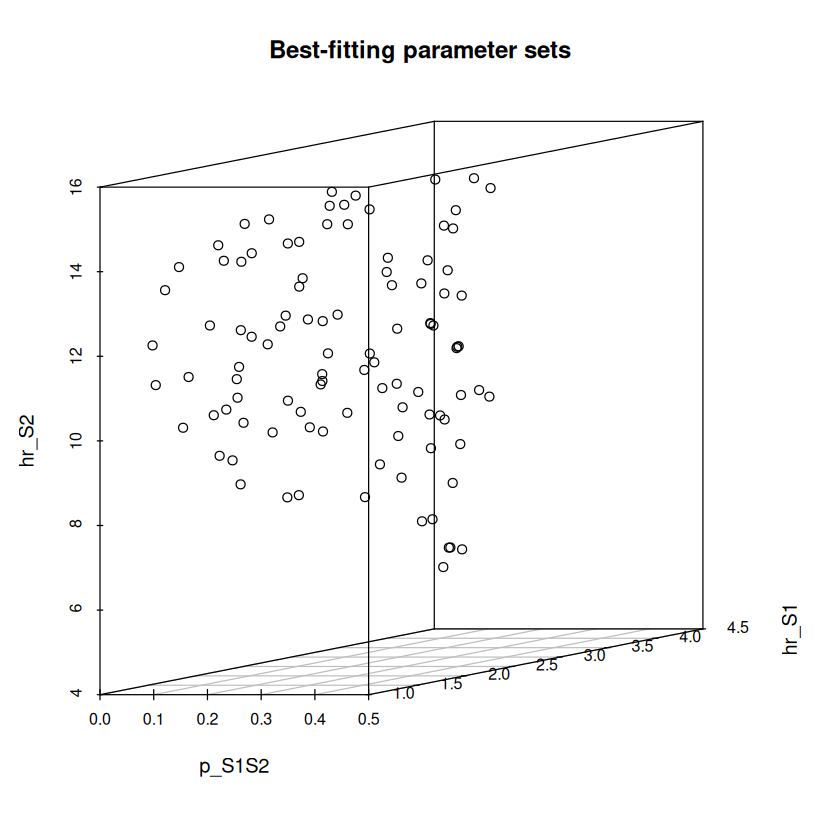

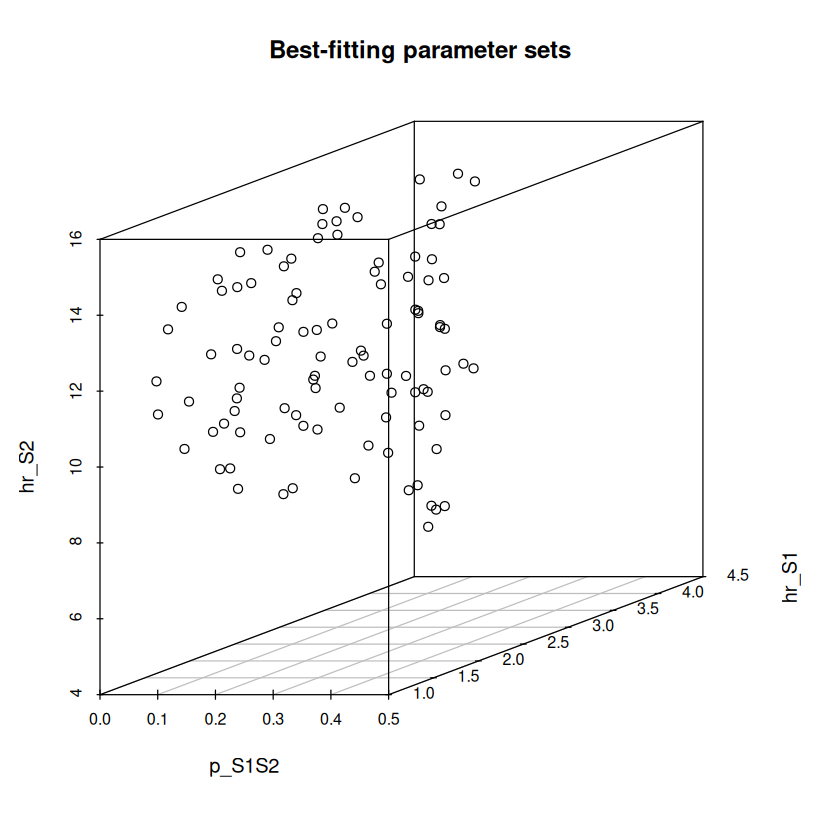

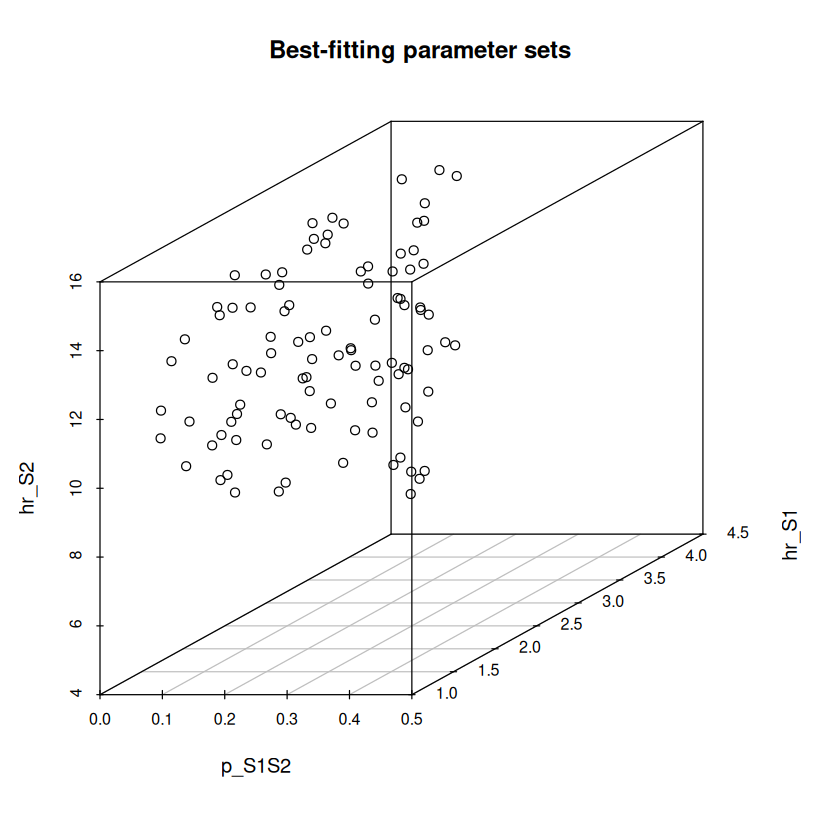

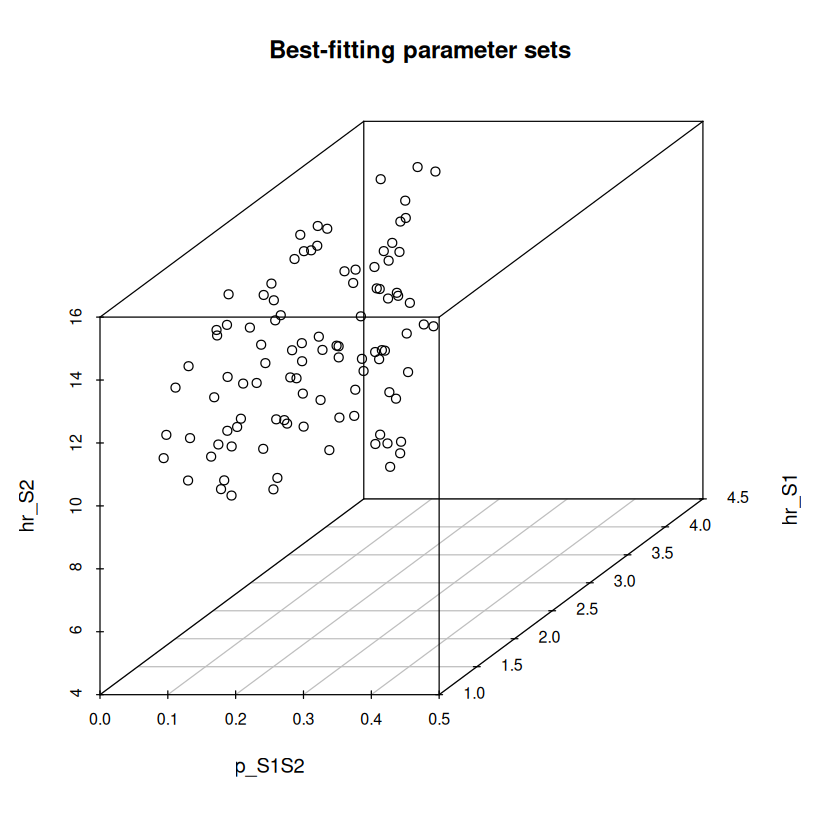

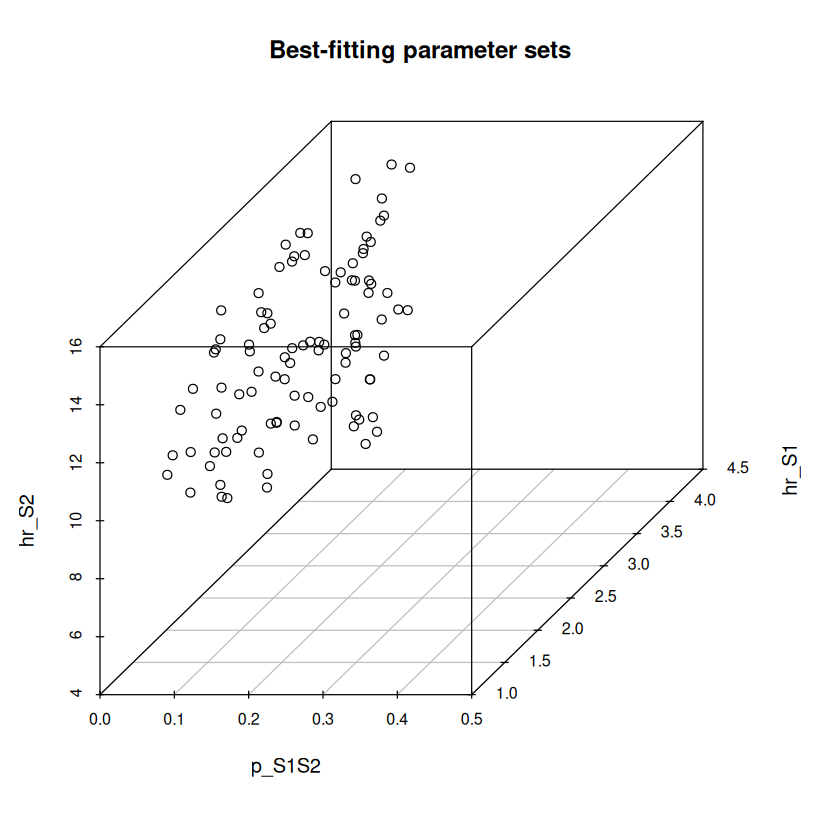

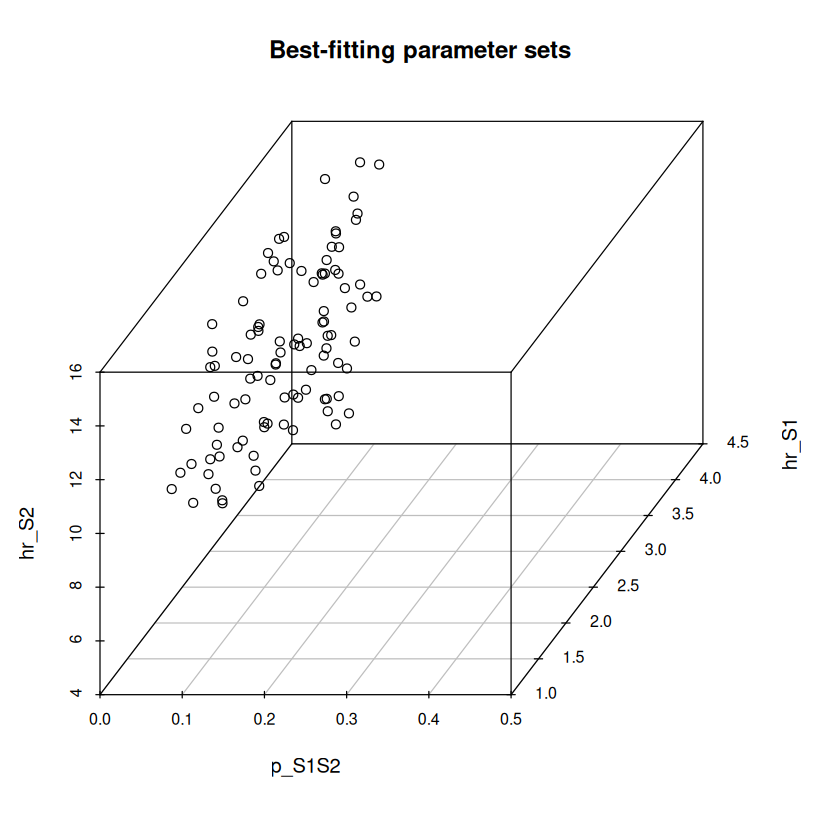

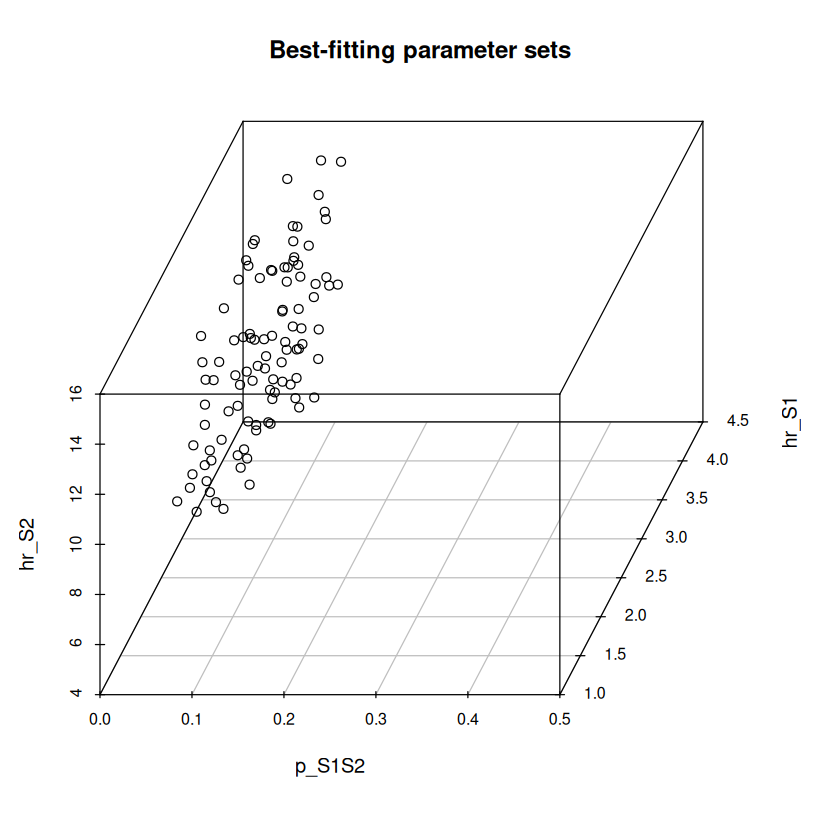

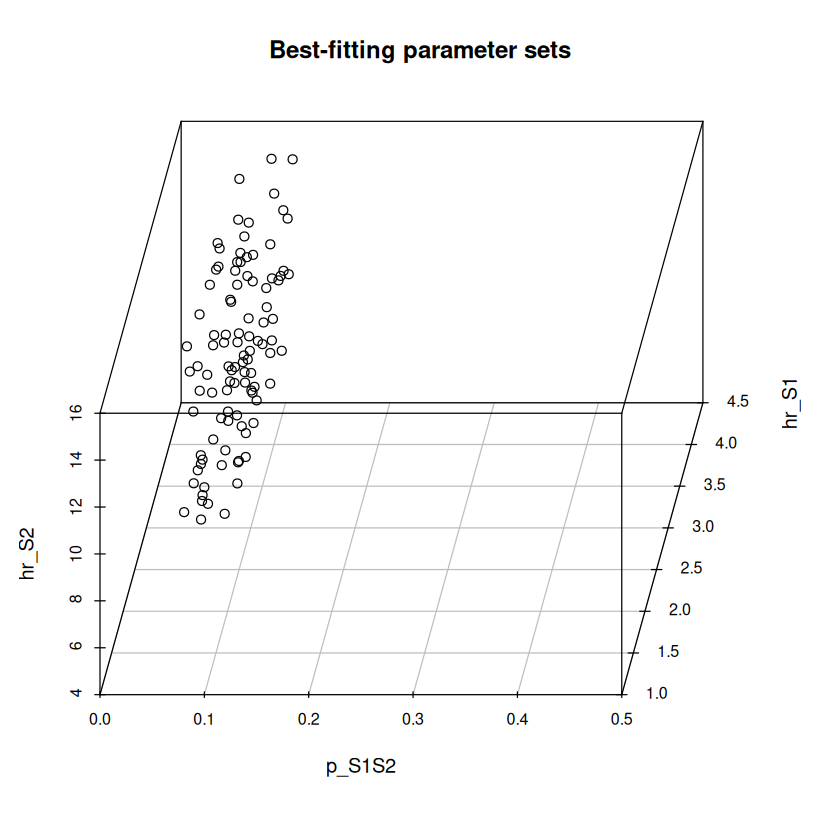

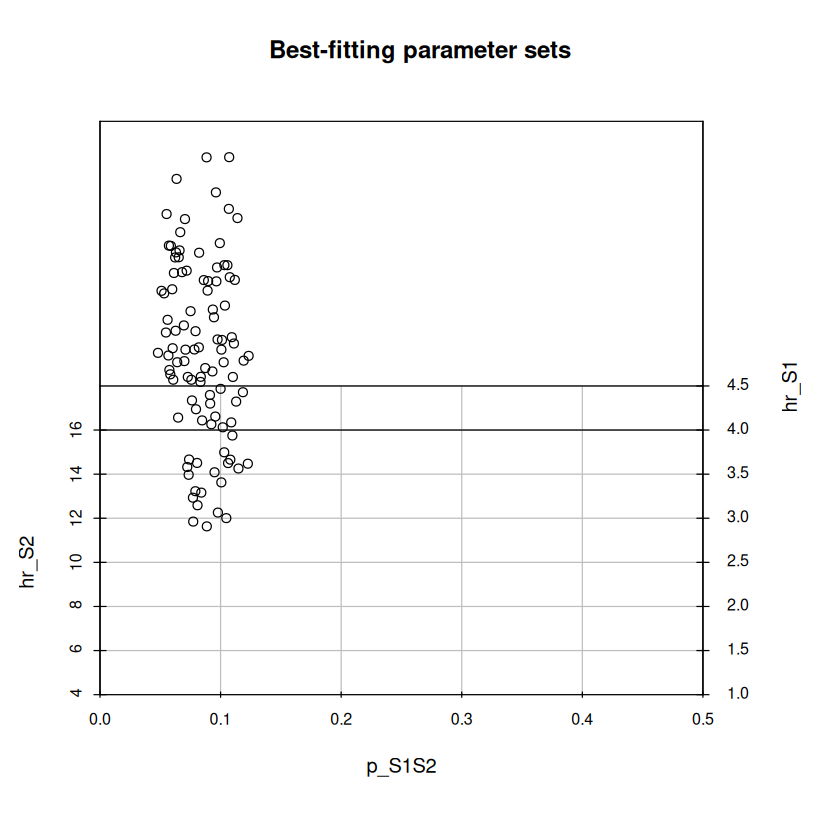

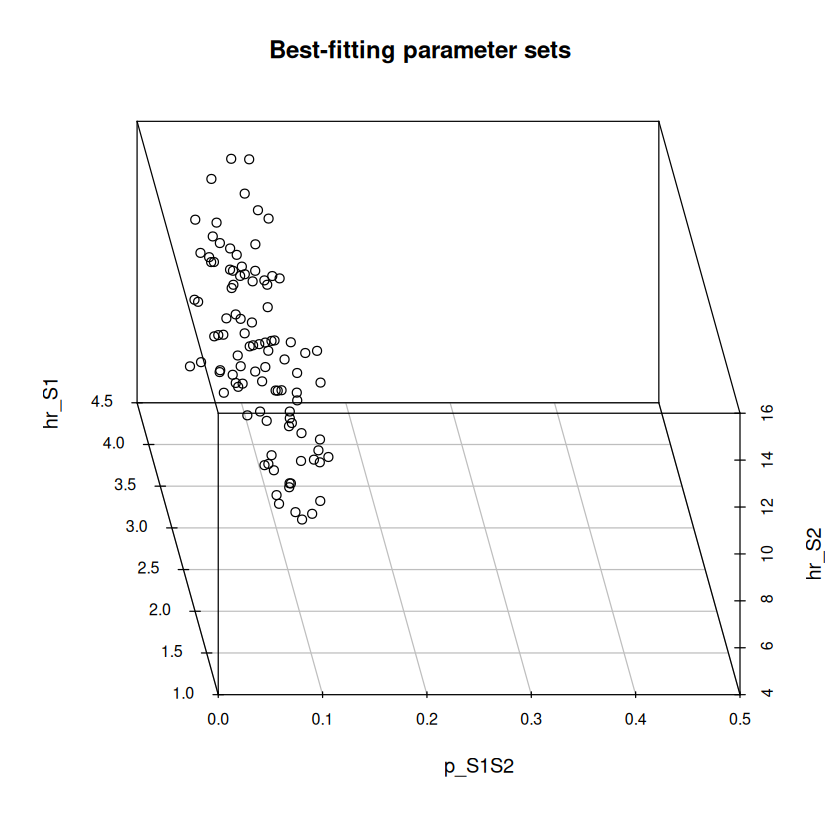

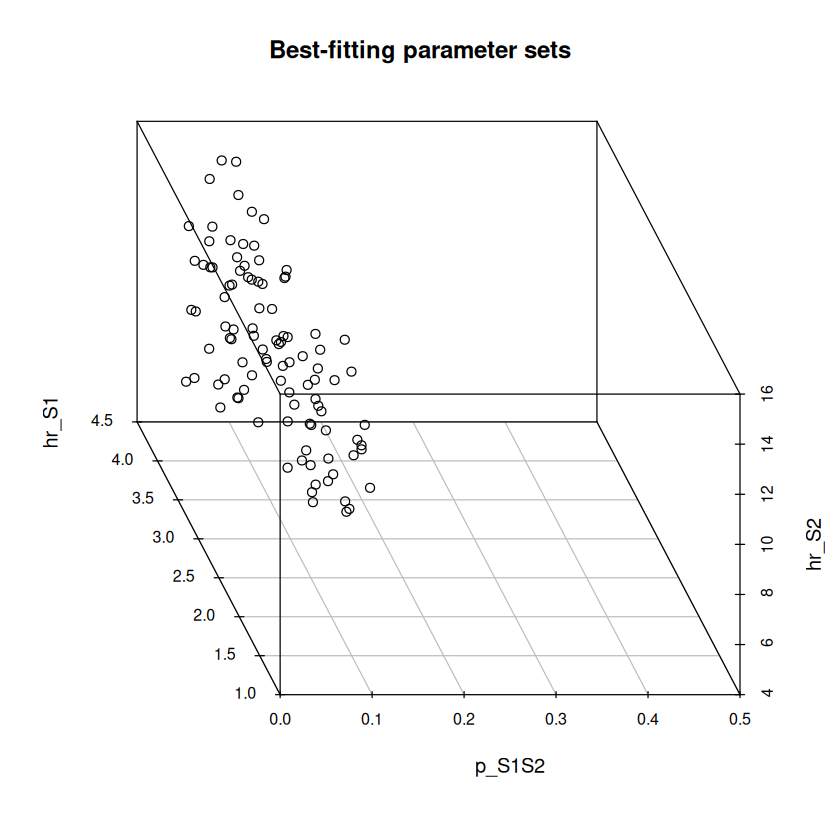

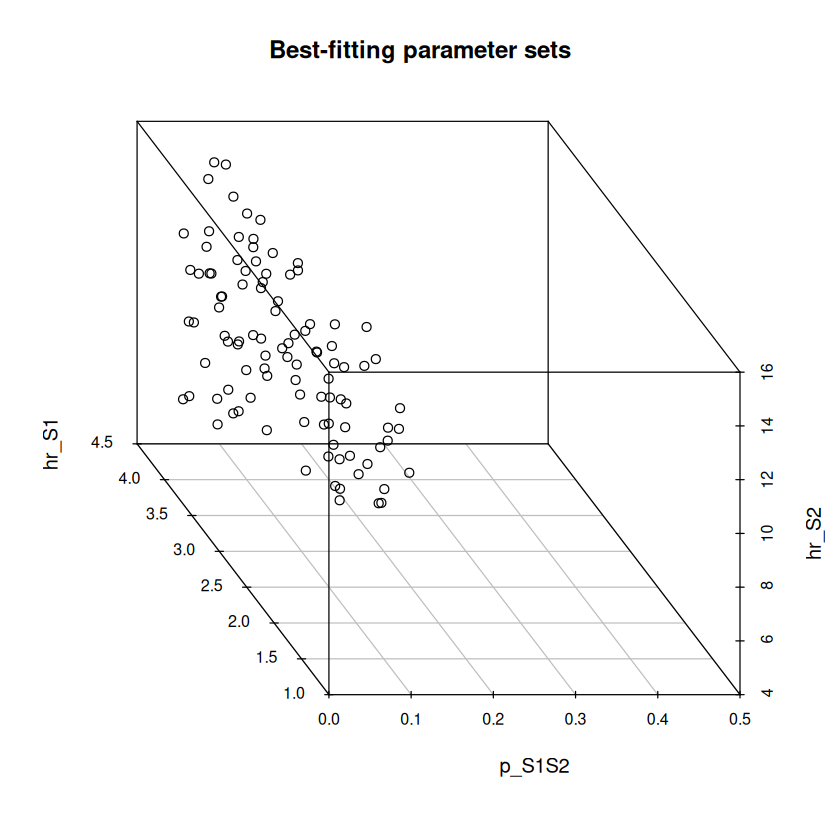

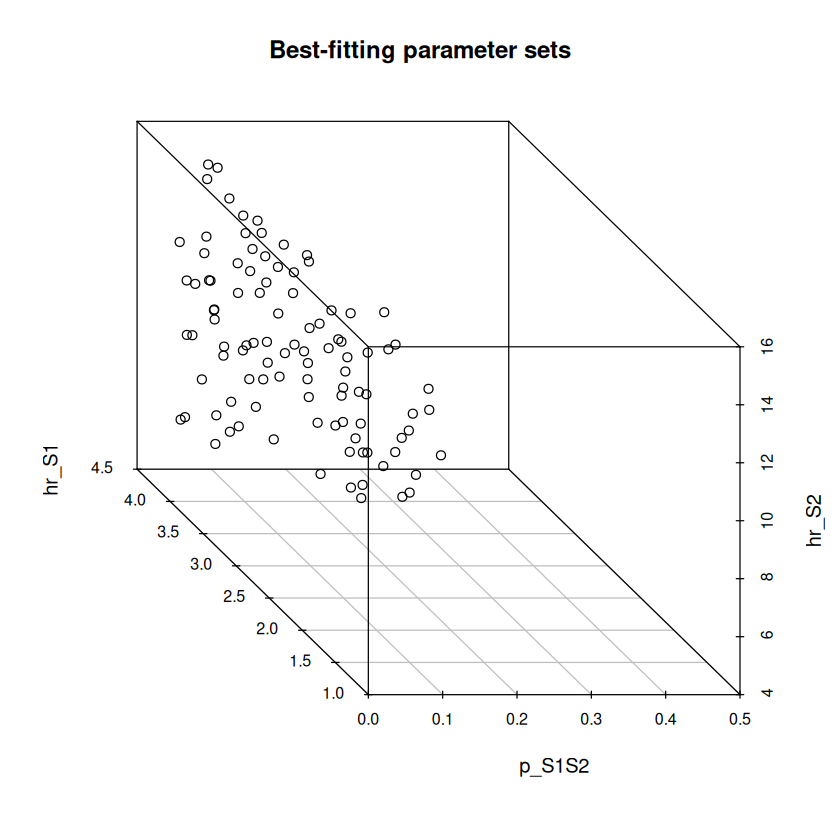

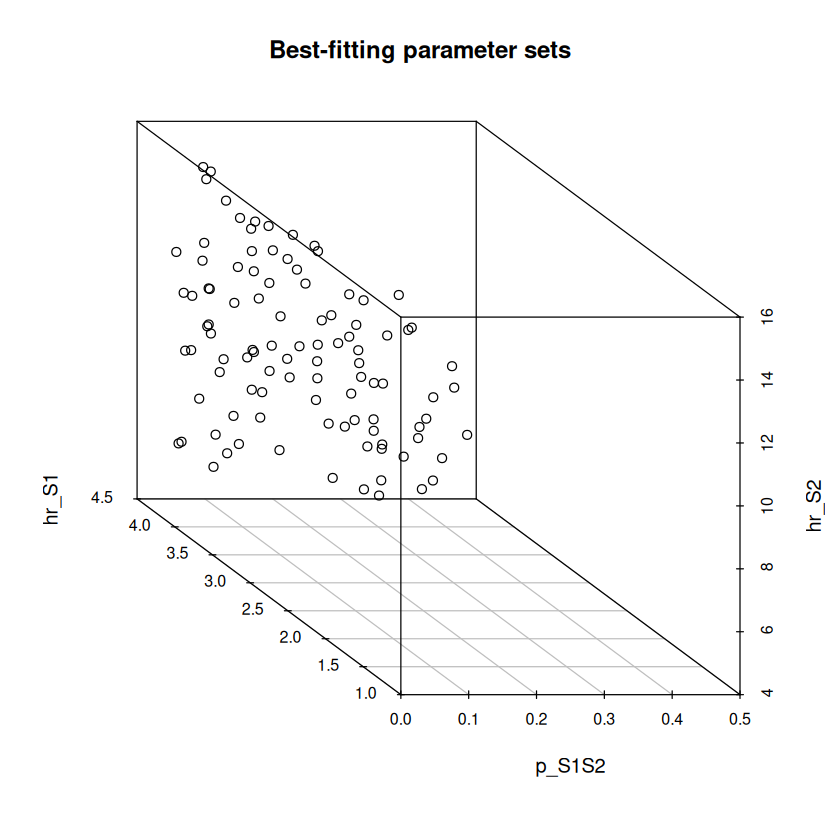

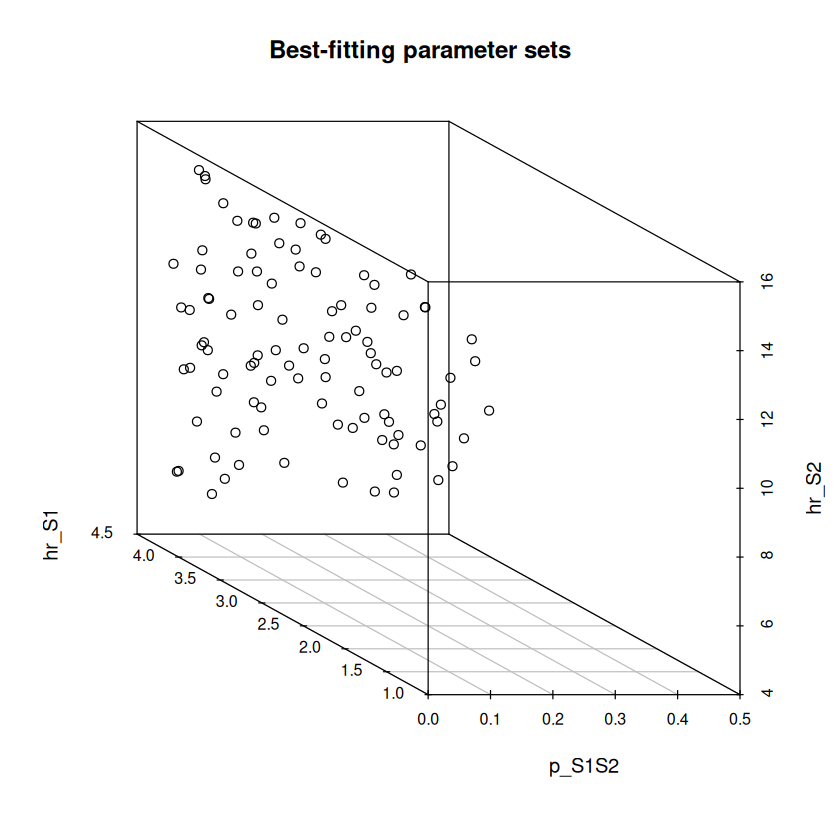

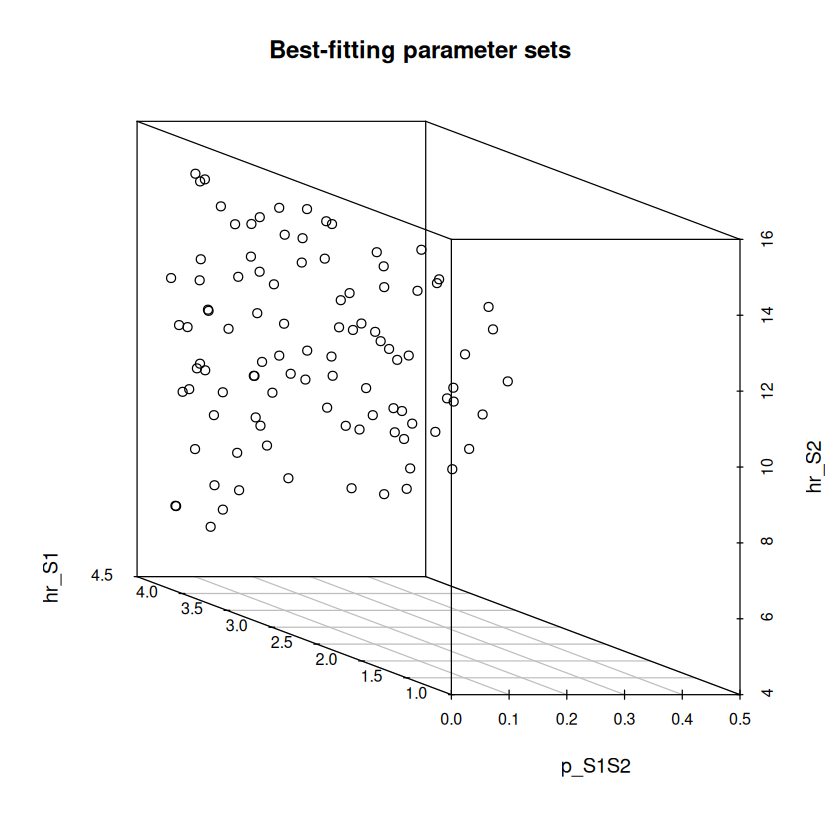

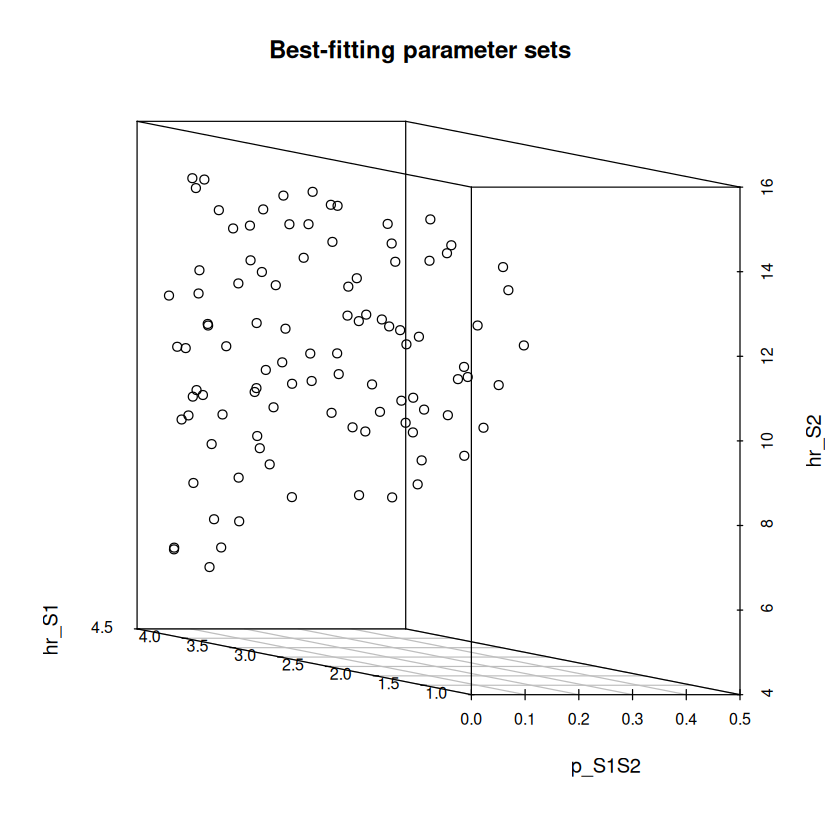

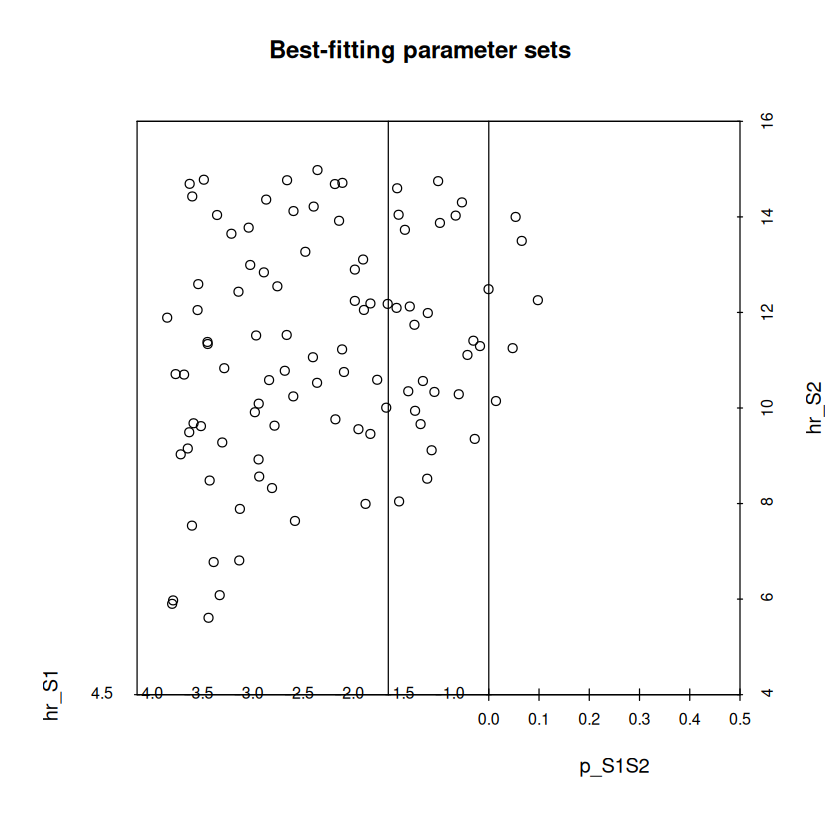

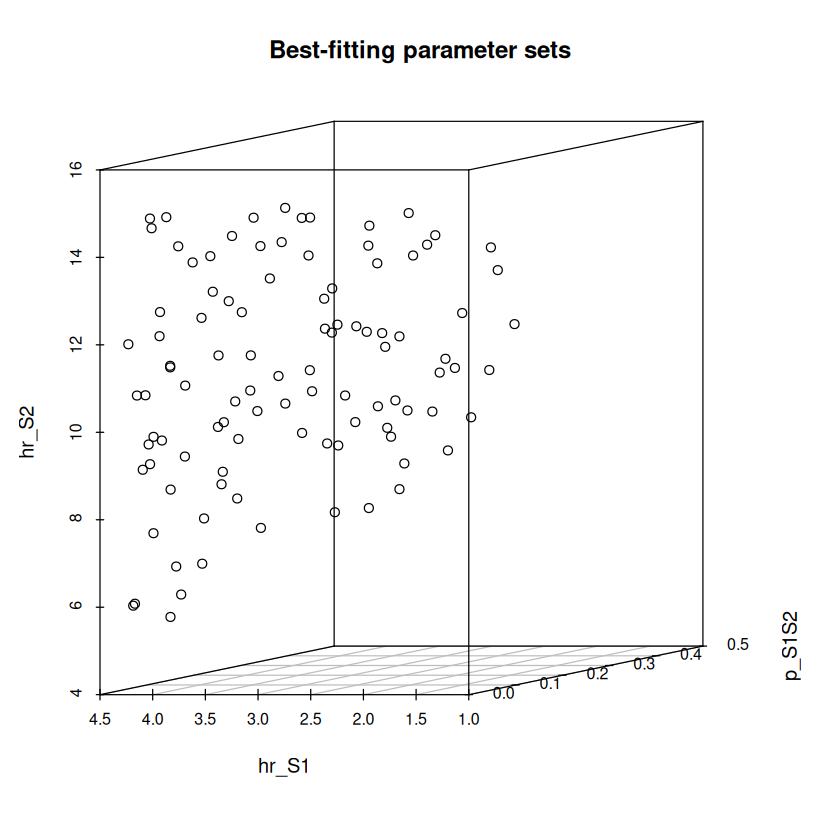

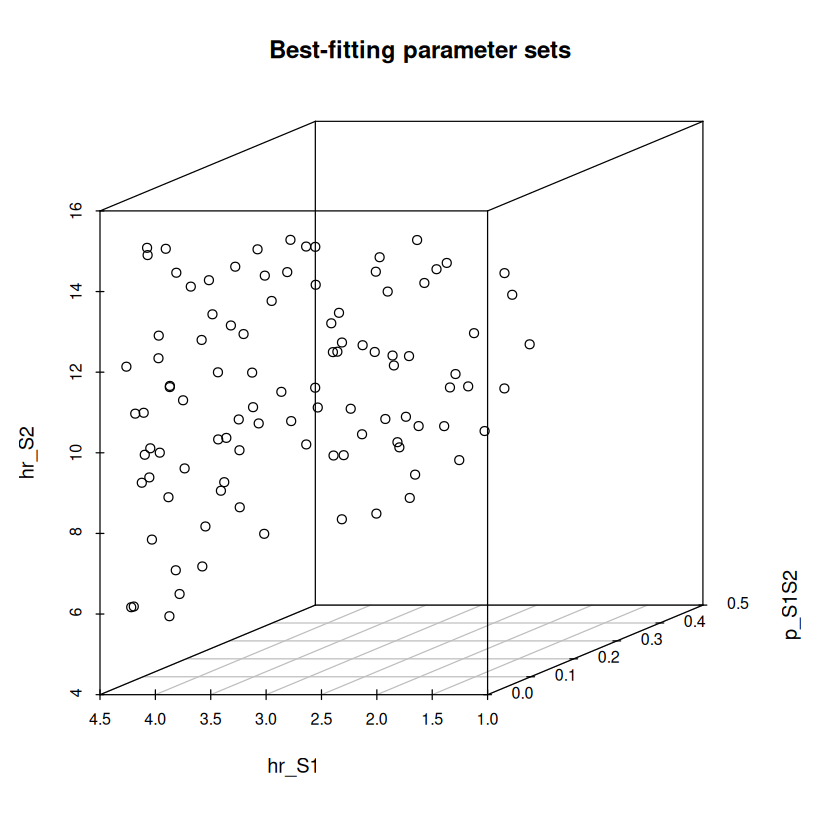

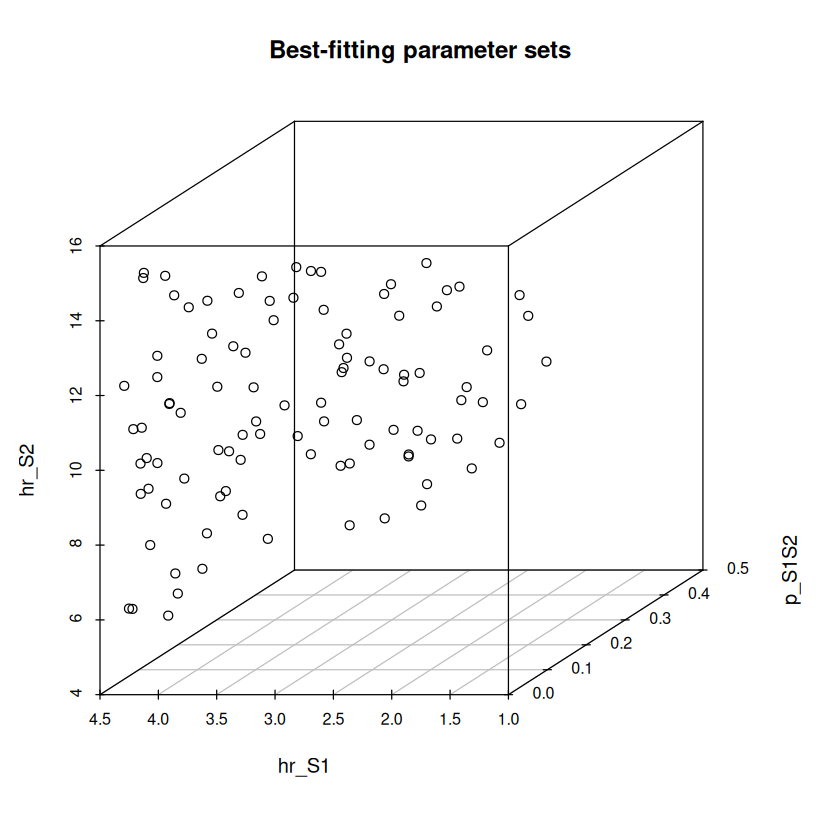

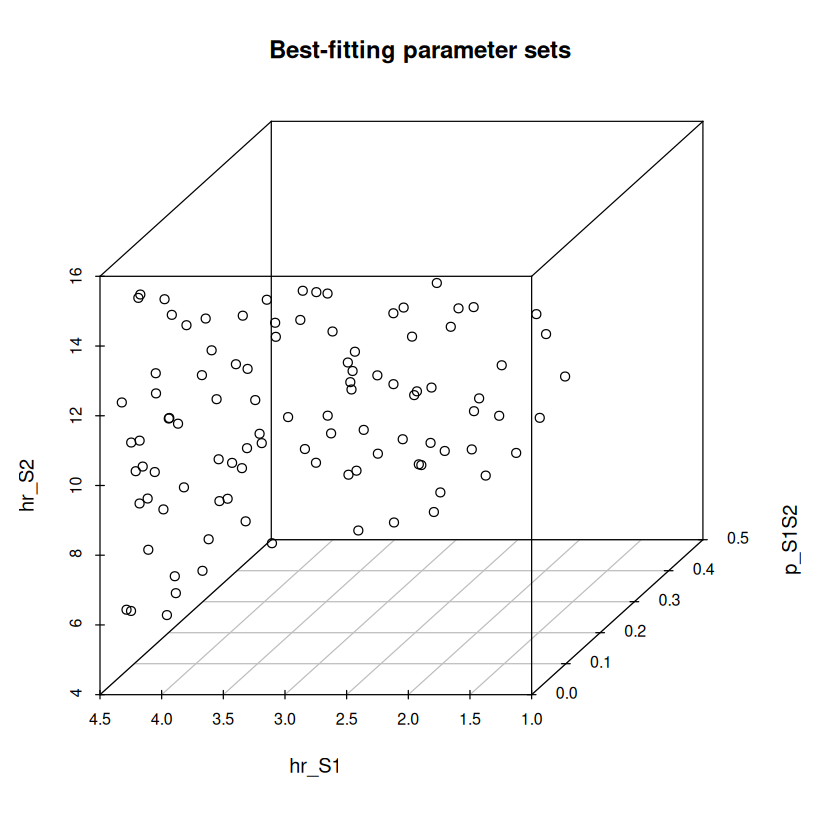

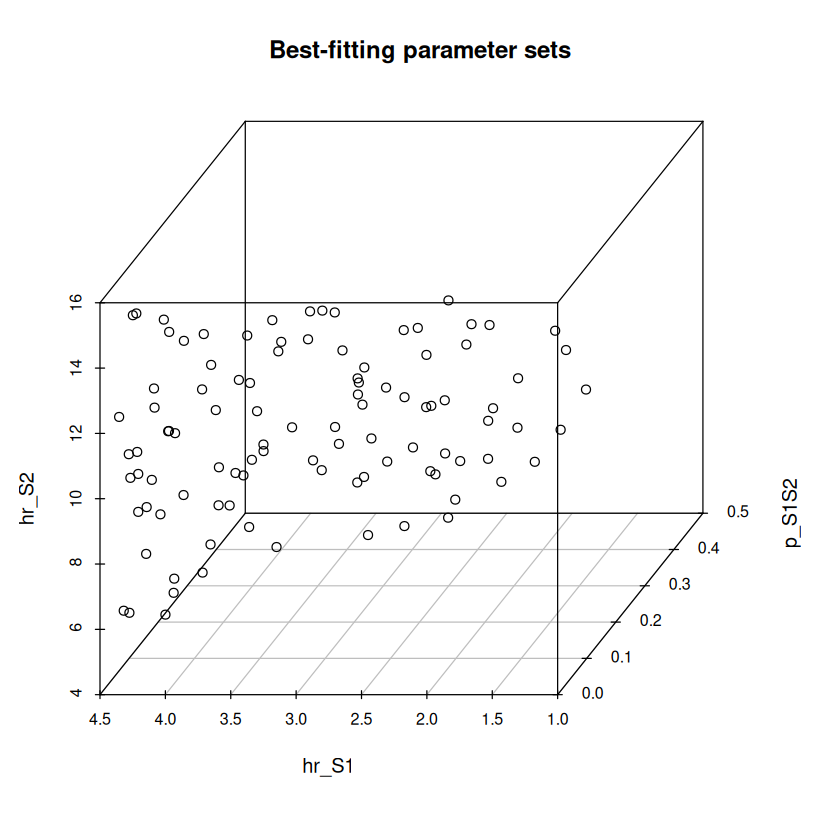

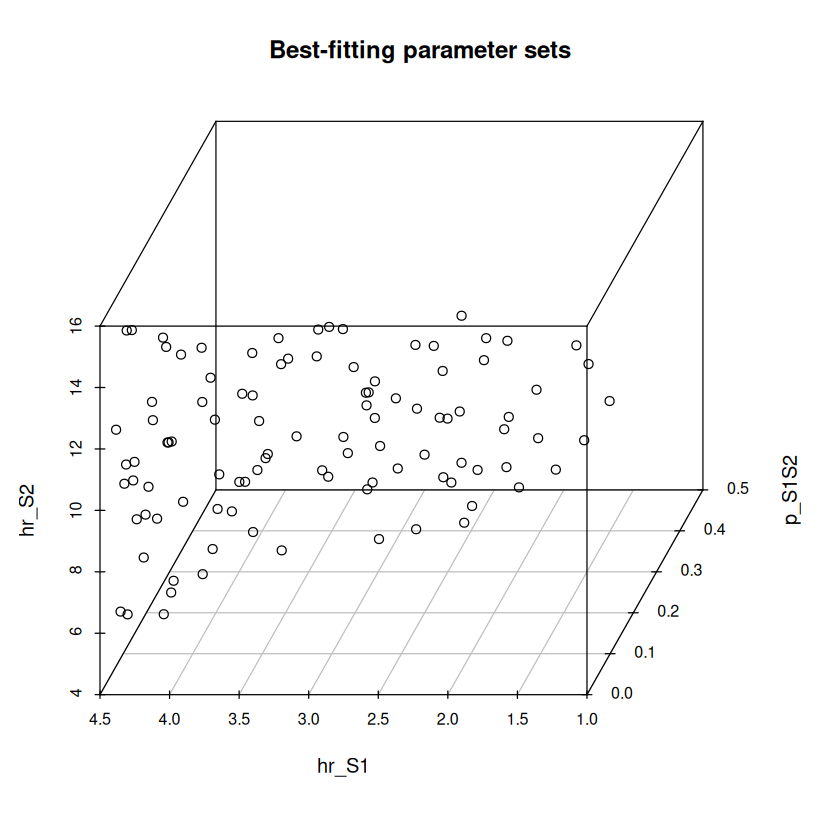

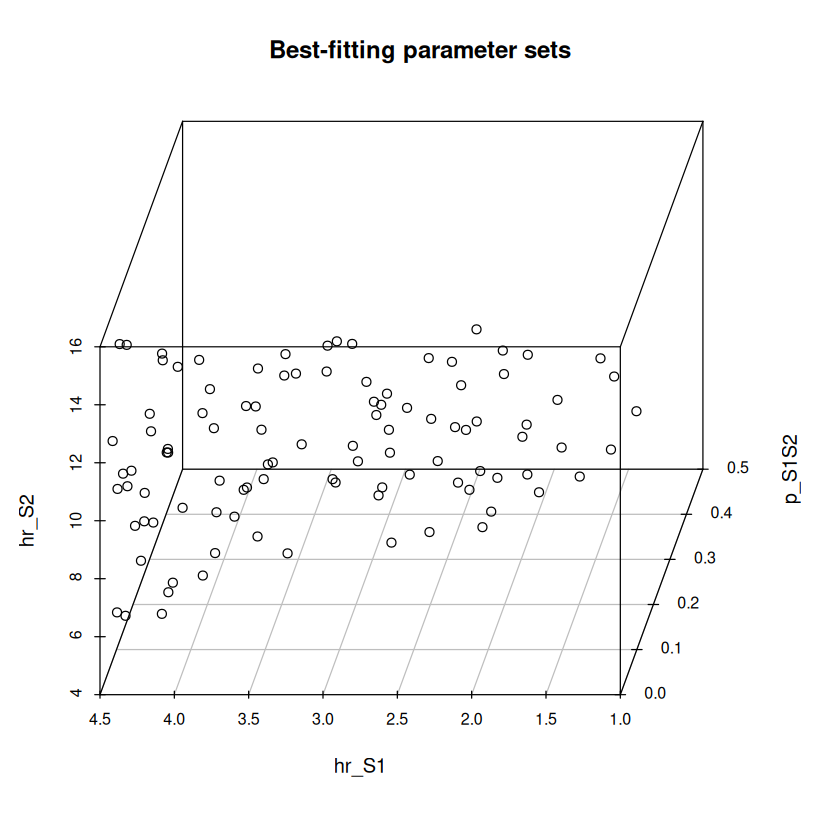

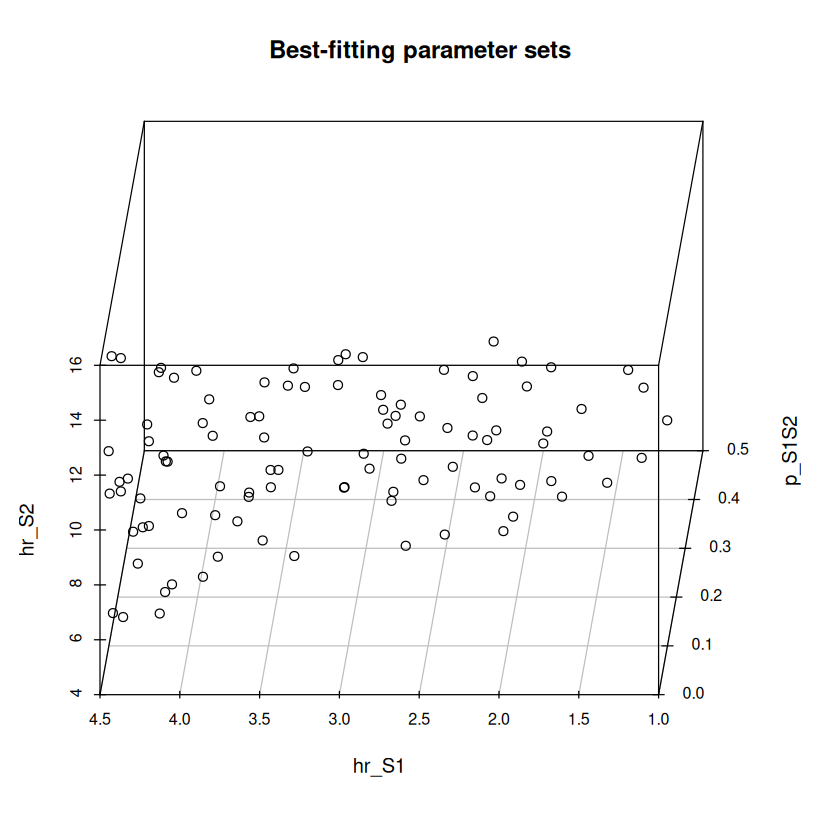

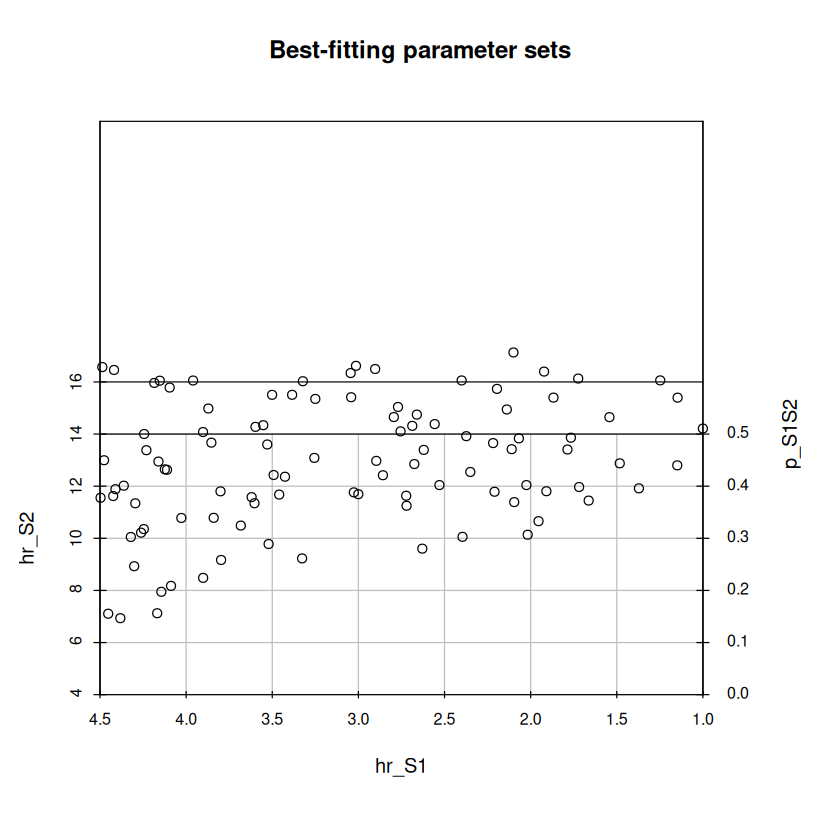

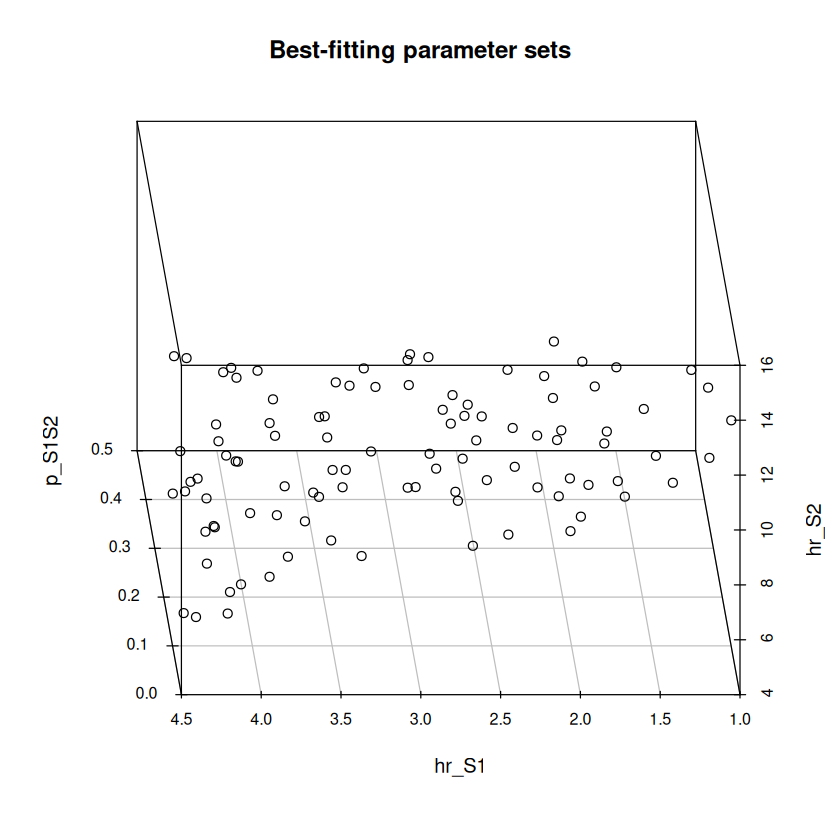

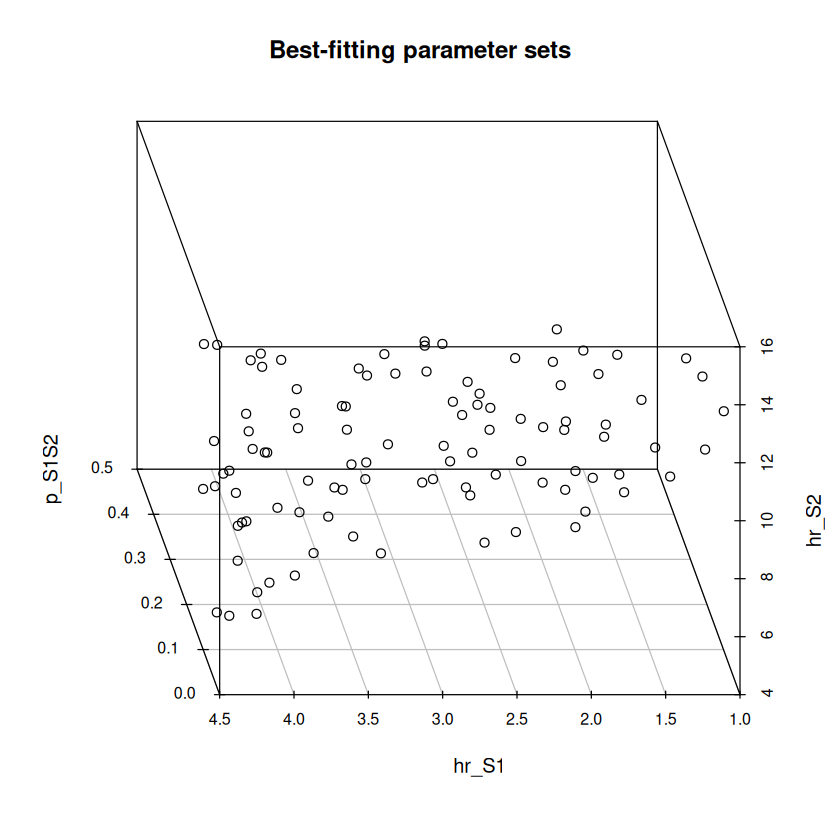

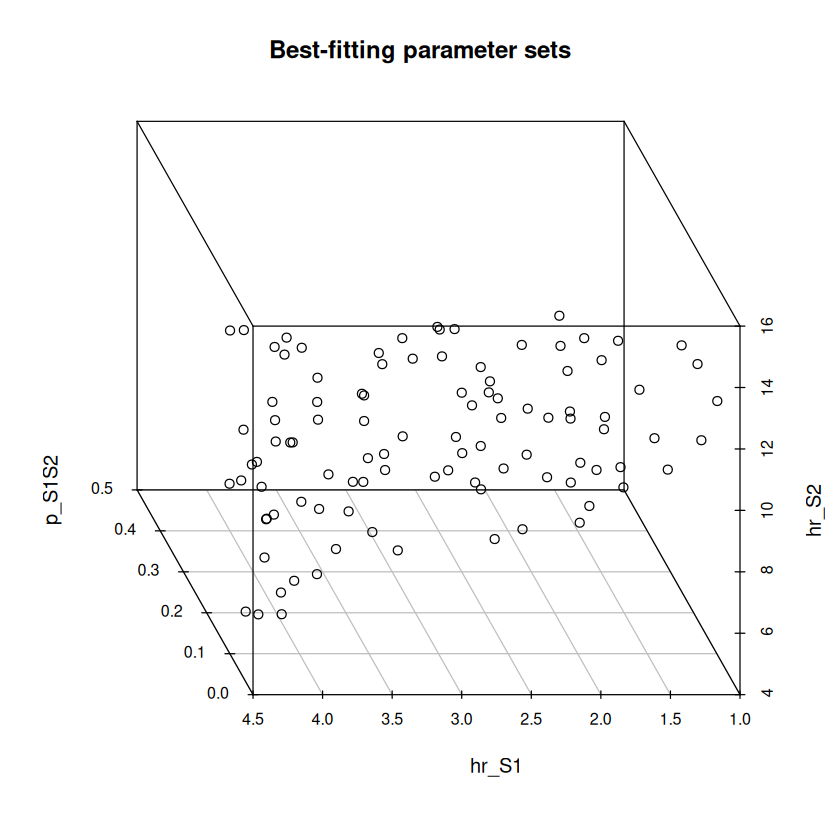

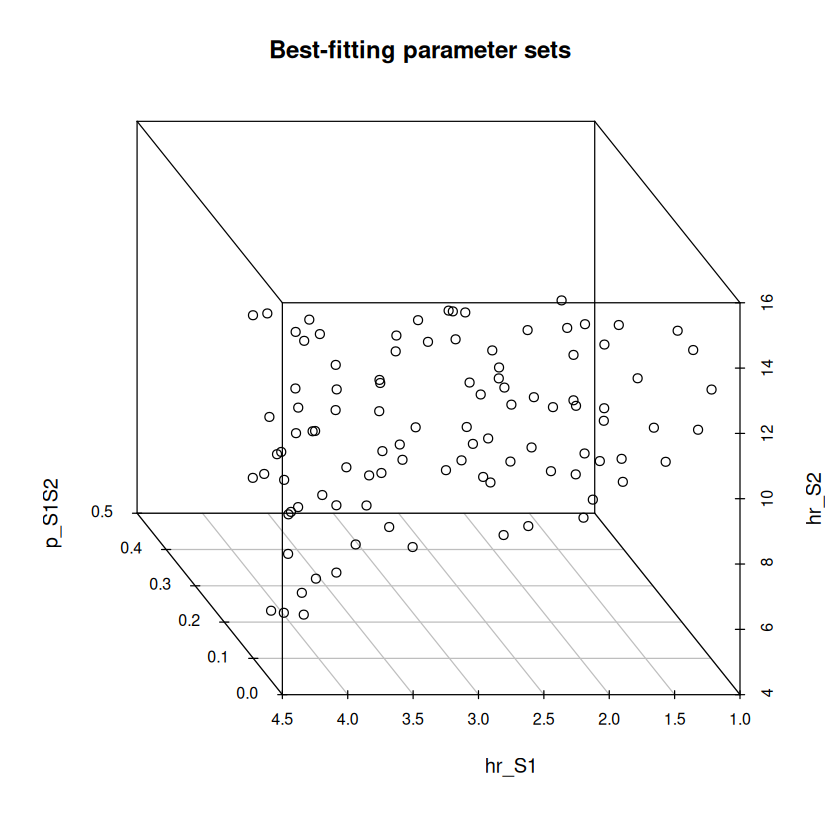

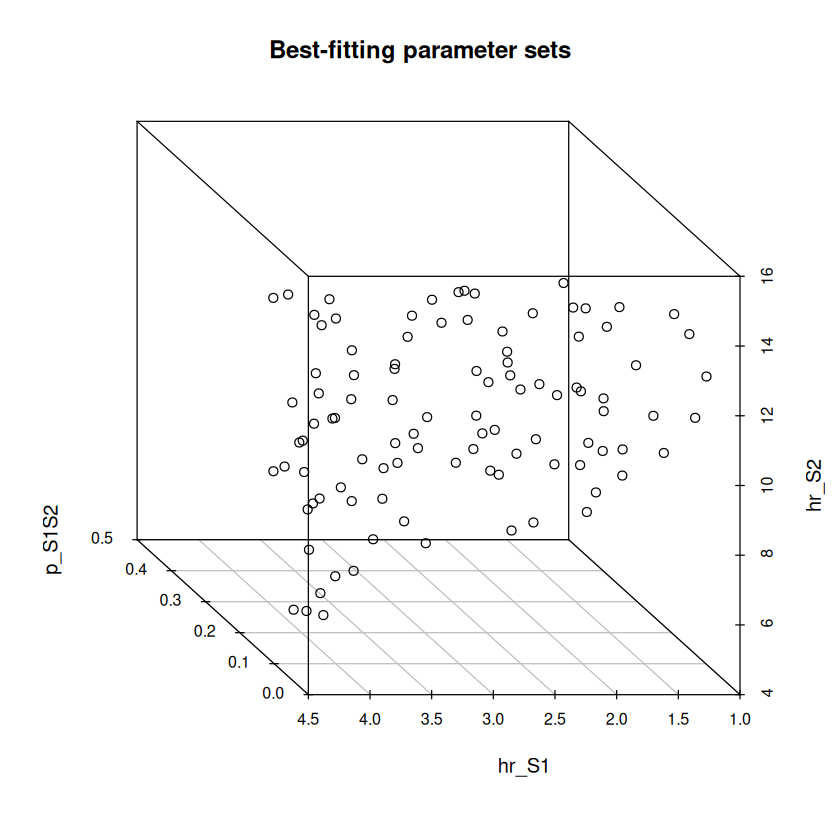

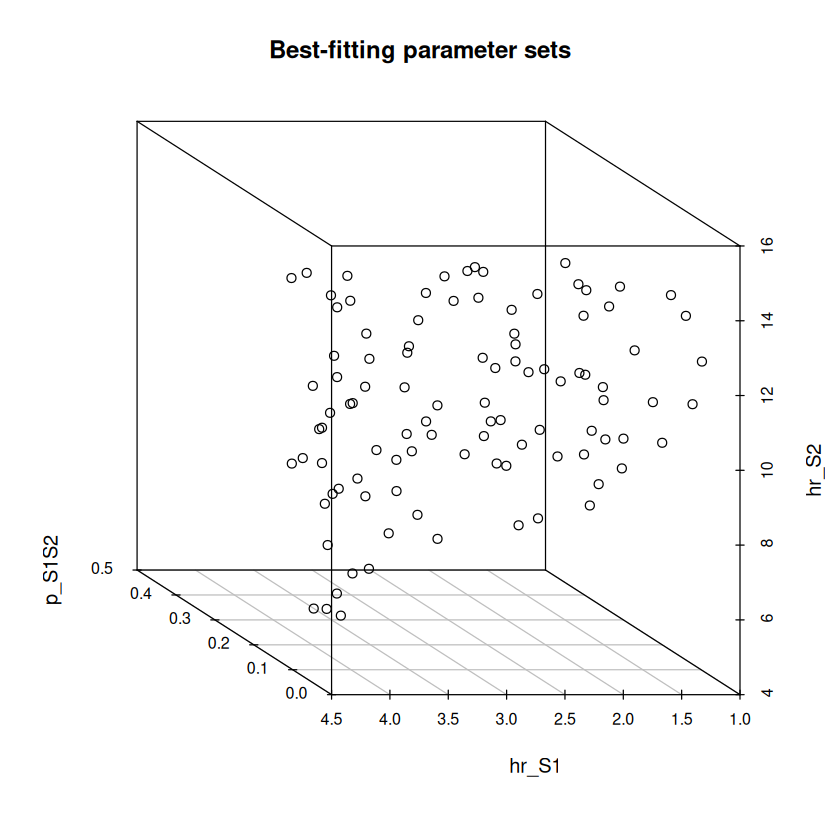

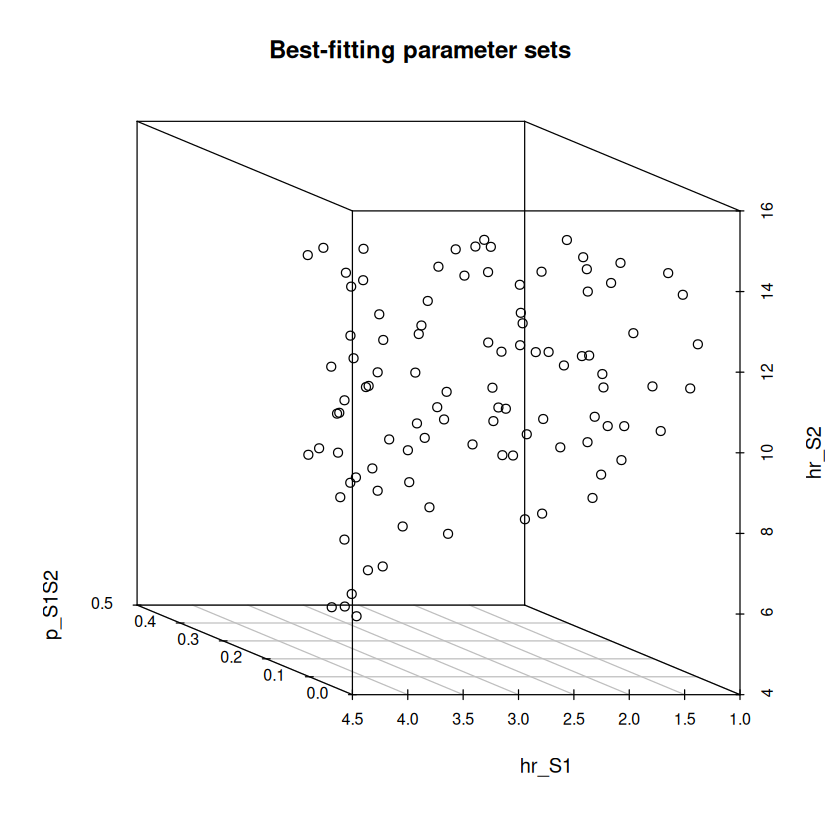

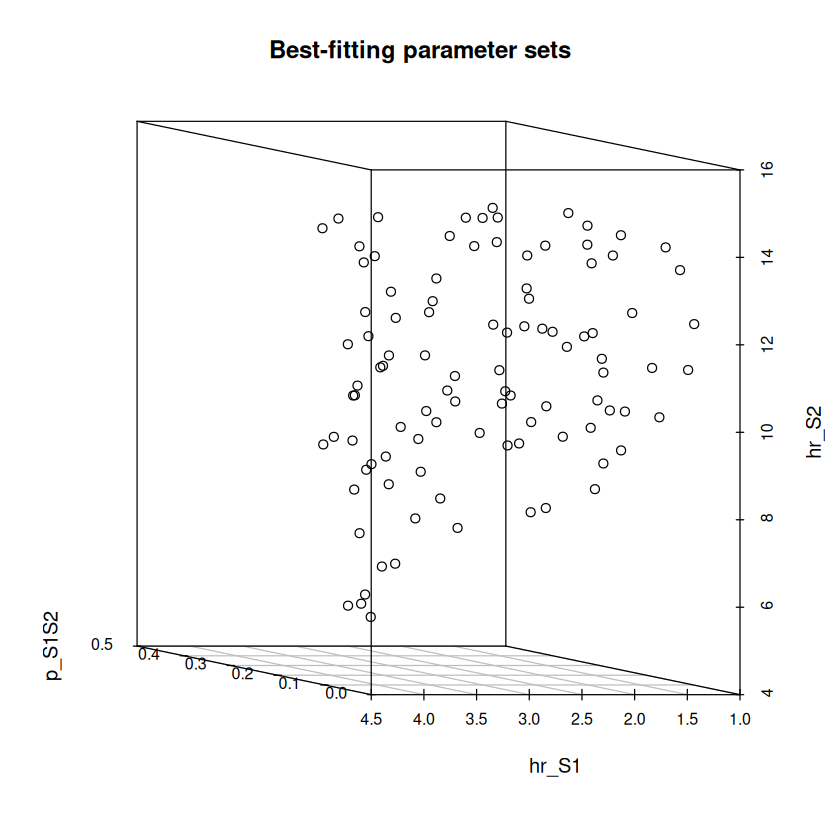

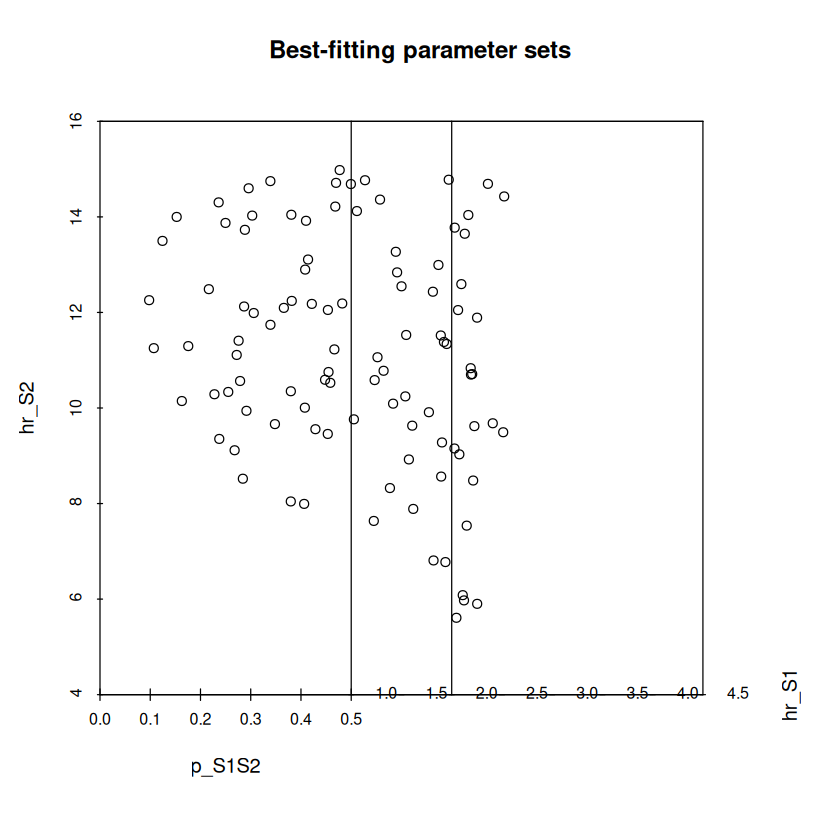

In [34]:
### 07.02 Visualize best-fitting parameter sets in 3D  -------------------------
# Plot the top 100 (top 10%)
topn=100
for(ang in seq(10,360,10)) {
    scatterplot3d(x = m_calib_res[1:topn, 1],
                  y = m_calib_res[1:topn, 2],
                  z = m_calib_res[1:topn, 3],
                  xlim = c(lb[1], ub[1]),
                  ylim = c(lb[2], ub[2]),
                  zlim = c(lb[3], ub[3]),
                  xlab = v_param_names[1],
                  ylab = v_param_names[2],
                  zlab = v_param_names[3],
                  main = "Best-fitting parameter sets", angle = ang)
}

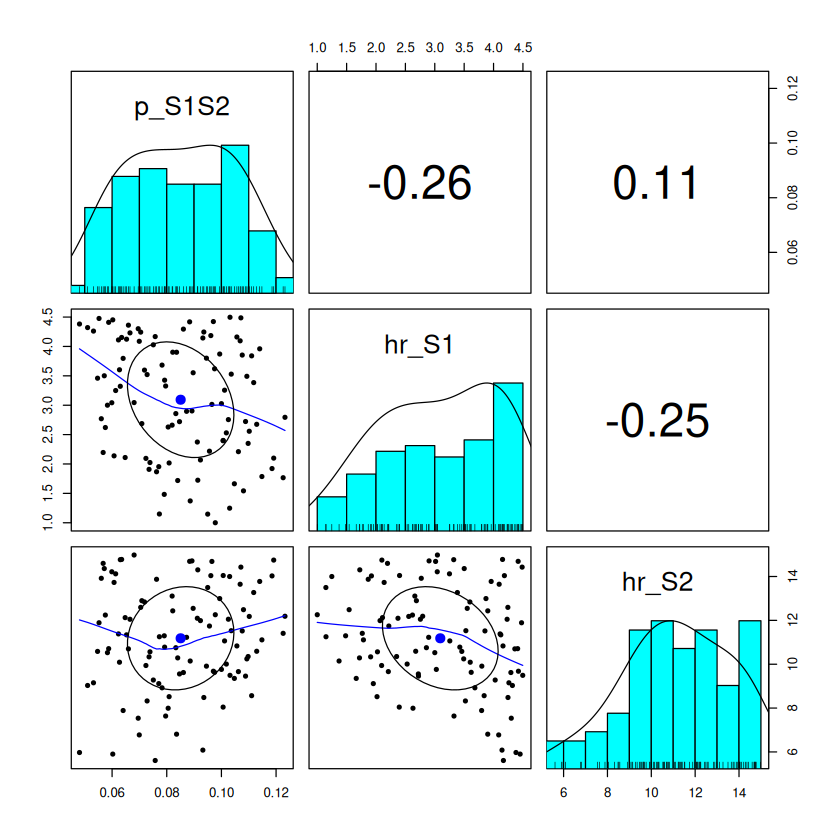

In [25]:
### 07.03 Pairwise plots of top parameter sets  --------------------------------
pairs.panels(m_calib_res[1:100, v_param_names])

### 07.04 Compare model predictions to targets  --------------------------------
# Compute output from best and worst parameter set
v_out_best  <- run_sick_sicker_markov(m_calib_res[1, ])
v_out_worst <- run_sick_sicker_markov(m_calib_res[n_samp, ])

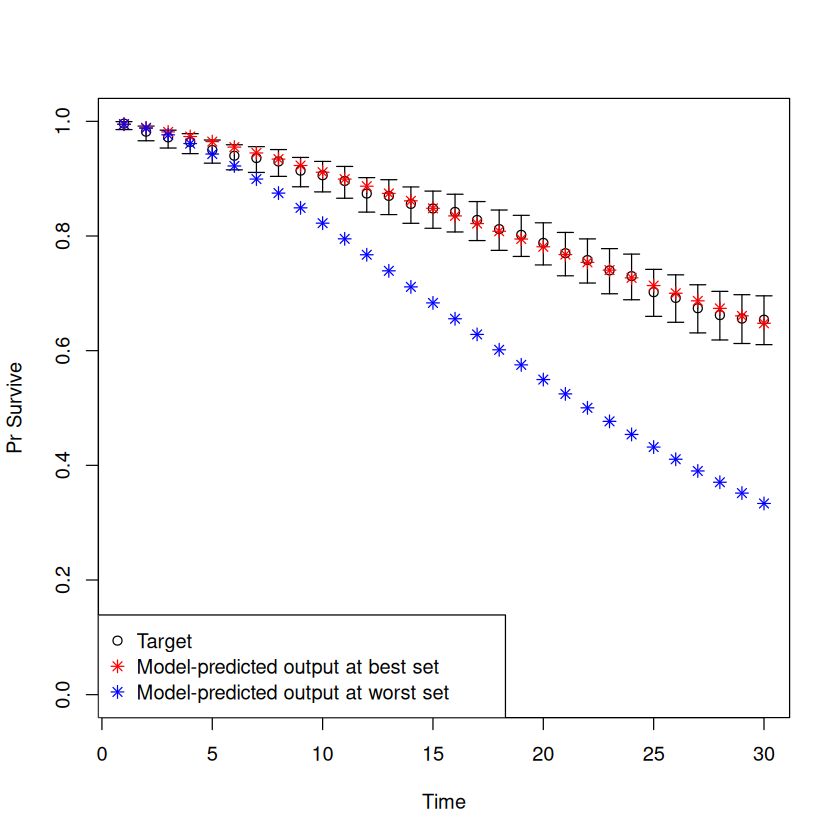

In [27]:
# Plot: TARGET 1: Survival ("Surv")
plotrix::plotCI(x = lst_targets$Surv$time, y = lst_targets$Surv$value,
                ui = lst_targets$Surv$ub,
                li = lst_targets$Surv$lb,
                ylim = c(0, 1),
                xlab = "Time", ylab = "Pr Survive")
points(x = lst_targets$Surv$time,
       y = v_out_best$Surv,
       pch = 8, col = "red")
points(x = lst_targets$Surv$time,
       y = v_out_worst$Surv,
       pch = 8, col = "blue")
legend("bottomleft",
       legend = c("Target",
                  "Model-predicted output at best set",
                  "Model-predicted output at worst set"),
       col = c("black", "red", "blue"),
       pch = c(1, 8, 8))

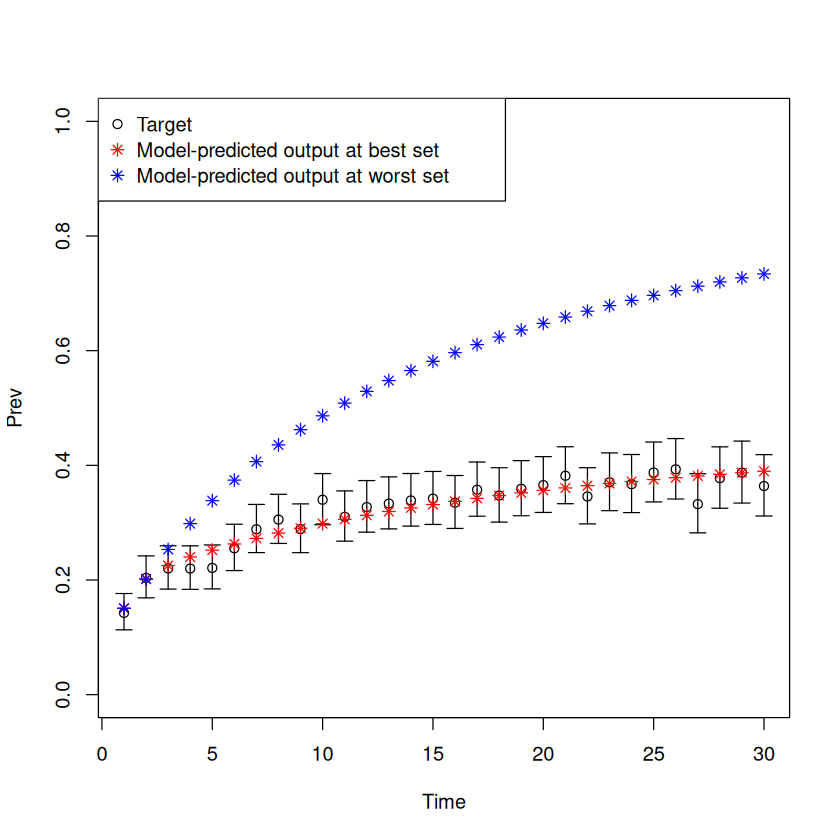

In [28]:
# Plot: TARGET 2: Prevalence ("Prev")
plotrix::plotCI(x = lst_targets$Prev$time, y = lst_targets$Prev$value,
                ui = lst_targets$Prev$ub,
                li = lst_targets$Prev$lb,
                ylim = c(0, 1),
                xlab = "Time", ylab = "Prev")
points(x = lst_targets$Prev$time,
       y = v_out_best$Prev,
       pch = 8, col = "red")
points(x = lst_targets$Prev$time,
       y = v_out_worst$Prev,
       pch = 8, col = "blue")
legend("topleft",
       legend = c("Target",
                  "Model-predicted output at best set",
                  "Model-predicted output at worst set"),
       col = c("black", "red", "blue"),
       pch = c(1, 8, 8))

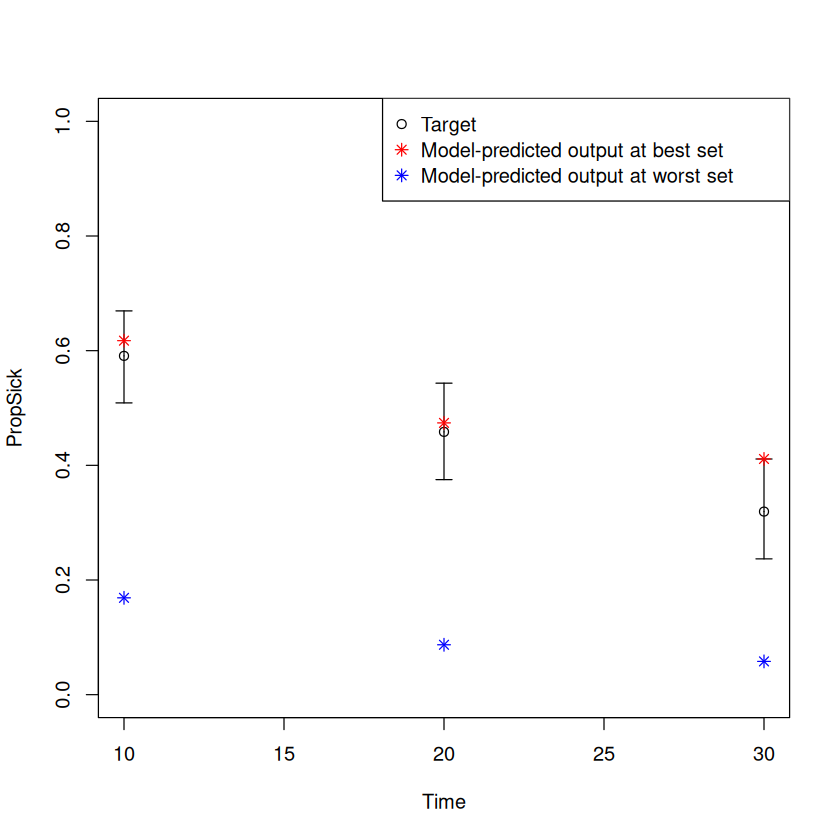

In [29]:
# Plot: TARGET 3: PropSick
plotrix::plotCI(x = lst_targets$PropSick$time, y = lst_targets$PropSick$value,
                ui = lst_targets$PropSick$ub,
                li = lst_targets$PropSick$lb,
                ylim = c(0, 1),
                xlab = "Time", ylab = "PropSick")
points(x = lst_targets$PropSick$time,
       y = v_out_best$PropSick,
       pch = 8, col = "red")
points(x = lst_targets$PropSick$time,
       y = v_out_worst$PropSick,
       pch = 8, col = "blue")
legend("topright",
       legend = c("Target",
                  "Model-predicted output at best set",
                  "Model-predicted output at worst set"),
       col = c("black", "red", "blue"),
       pch = c(1, 8, 8))